### Setup

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from collections import Counter
from scipy.cluster.vq import kmeans, whiten, vq
from scipy.spatial.distance import cdist
iris = datasets.load_iris()

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Separate Iris data and target classes

In [59]:
X = iris.data
X_std = StandardScaler().fit_transform(iris.data)
y = iris.target

In [55]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

### Plot Petal Width vs Sepal Width for comparison

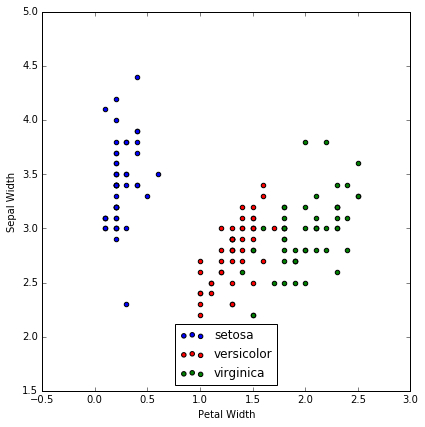

In [56]:
plt.figure(figsize=(6, 6))
for lab, num, col in zip(('setosa', 'versicolor', 'virginica'), (0,1,2),
                    ('blue', 'red', 'green')):
    plt.scatter(iris.data[y==num, 3],
                iris.data[y==num, 1],
                label=lab,
                c=col)
plt.xlabel('Petal Width')
plt.ylabel('Sepal Width')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

### PCA transform on Iris data 

In [13]:
pca = PCA(n_components=2)
Y_sklearn = pca.fit_transform(iris.data)

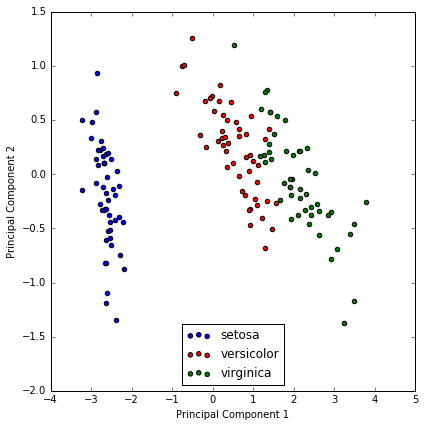

In [53]:
plt.figure(figsize=(6, 6))
for lab, num, col in zip(('setosa', 'versicolor', 'virginica'), (0,1,2),
                    ('blue', 'red', 'green')):
    plt.scatter(Y_sklearn[y==num, 0],
                Y_sklearn[y==num, 1],
                label=lab,
                c=col)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

### K-Nearest Neighbors return the same classes for the two test cases after PCA

In [91]:
def knneucl(sep_length, sep_width, k):
    def f(x):
        return np.sqrt((sep_length - x[0])**2 + (sep_width - x[1])**2)
    dist = np.apply_along_axis(f, 1, pca.inverse_transform(Y_sklearn))  
            # Inverse_transforms gives the original values so you can use non-standardized values in knn
    return Counter(iris.target_names[y[dist.argsort()[:k]]])

In [92]:
knneucl(5.0, 4.0, 10)

Counter({'setosa': 10})

In [93]:
knneucl(5.2, 3.0, 10)

Counter({'setosa': 8, 'versicolor': 2})

### How much variance is explained by the first 2 features

In [38]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[ 0.92461621  0.05301557]
0.977631775025


In [49]:
pca.get_covariance()

array([[ 0.67466942, -0.03236894,  1.26219343,  0.52863729],
       [-0.03236894,  0.17992281, -0.3165114 , -0.13274474],
       [ 1.26219343, -0.3165114 ,  3.09854983,  1.27684583],
       [ 0.52863729, -0.13274474,  1.27684583,  0.58568727]])

### Eigenvectors and Eigenvalues for iris data

In [46]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.93035378  0.92740362  0.14834223  0.02074601]


In [45]:
u,s,v = np.linalg.svd(X_std.T)
u

array([[-0.52237162, -0.37231836,  0.72101681,  0.26199559],
       [ 0.26335492, -0.92555649, -0.24203288, -0.12413481],
       [-0.58125401, -0.02109478, -0.14089226, -0.80115427],
       [-0.56561105, -0.06541577, -0.6338014 ,  0.52354627]])

### Using all of the data, first 2 features account for nearly all variance

In [50]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

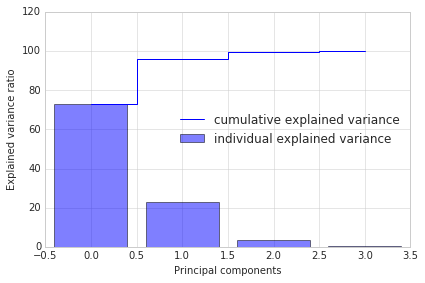

In [51]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [60]:
# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

### LDA plot for Iris data

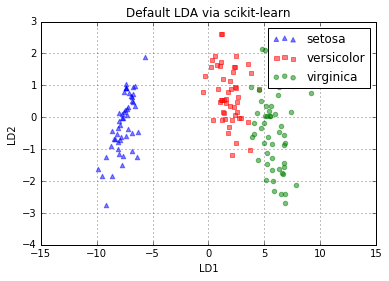

In [63]:
def plot_scikit_lda(X):

    ax = plt.subplot(111)
    for label,num,marker,color in zip(
        ('setosa', 'versicolor', 'virginica'),(0,1,2),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == num],
                    y=X[:,1][y == num] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label)

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    plt.legend(loc='upper right')
    plt.title('Default LDA via scikit-learn')
  

    plt.grid()
    plt.tight_layout
    plt.show()
    
plot_scikit_lda(X_lda_sklearn)

### LDA using UN data

In [115]:
undata = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/curric-data-001-data-sets/master/un/un.csv')
undata.head()

,country,region,tfr,contraception,educationMale,educationFemale,lifeMale,lifeFemale,infantMortality,GDPperCapita,economicActivityMale,economicActivityFemale,illiteracyMale,illiteracyFemale
0,Afghanistan,Asia,6.90,NaN,NaN,NaN,45.0,46.0,154.0,2848.0,87.5,7.2,52.800,85.00
1,Albania,Europe,2.60,NaN,NaN,NaN,68.0,74.0,32.0,863.0,NaN,NaN,NaN,NaN
2,Algeria,Africa,3.81,52.0,11.1,9.9,67.5,70.3,44.0,1531.0,76.4,7.8,26.100,51.00
3,American.Samoa,Asia,NaN,NaN,NaN,NaN,68.0,73.0,11.0,NaN,58.8,42.4,0.264,0.36
4,Andorra,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert GDP per capita to 3 classes

In [127]:
undata.dropna(inplace = True)
def f(z):
    if z > 20000:
        return 2
    elif z > 5500:
        return 1
    else:
        return 0
x = undata[['lifeMale', 'lifeFemale', 'infantMortality', 'GDPperCapita']]
y_un = [ f(z) for z in x['GDPperCapita'] ]
print(y_un)

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0]


In [128]:
# LDA
undata_lda = LDA(n_components=2)
X_lda_undata = undata_lda.fit_transform(x.iloc[:,0:3],y_un)

### Plot UN LDA

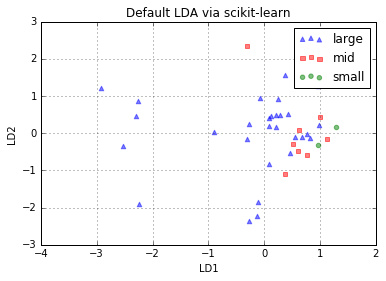

In [136]:
def plot_undata_lda(un):

    ax = plt.subplot(111)
    for label,num,marker,color in zip(
        ('large', 'mid', 'small'),(0,1,2),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=un[:,0][np.array(y_un) == num],
                    y=un[:,1][np.array(y_un) == num] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label)

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    plt.legend(loc='upper right')
    plt.title('Default LDA via scikit-learn')
  

    plt.grid()
    plt.tight_layout
    plt.show()
    
plot_undata_lda(X_lda_undata)